# Terceiro Trabalho de Introdução à Computação Visual


Arthur Pontes Nader <br>
Luiz Philippe Pereira Amaral <br>
Rita Rezende Borges de Lima

## Instalação de bibliotecas e módulos

In [57]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score

## Pré Processamento


Inicialmente declaramos duas funções de conversão, ```char_to_int(x)```, que dado um caracter __x__, retorna seu valor inteiro correspondente e a função contrária ```int_to_char(x)``` que dado um inteiro retorna seu respectivo caractér.

In [8]:
def char_to_int(x):
    return {"0" : 0, "1" : 1, "2" : 2, "3" : 3, "4" : 4, "5" : 5, "6" : 6, "7" : 7, "8" : 8, "9" : 9, \
     "A" : 10, "B" : 11, "C" : 12, "D" : 13, "E" : 14, "F" : 15, "G" : 16, "H" : 17, "I" : 18,        \
     "J" : 19, "K" : 20, "L" : 21, "M" : 22, "N" : 23, "O" : 24, "P" : 25, "Q" : 26, "R" : 27,        \
     "S" : 28, "T" : 29, "U" : 30, "V" : 31, "X" : 32, "W" : 33, "Y" : 34, "Z" : 35, "?": 36}[x]

def int_to_char(x):
    return {0 : "0", 1 : "1", 2 : "2", 3 : "3", 4 : "4", 5 : "5", 6 : "6", 7 : "7", 8: "8", 9: "9", \
     10 : "A", 11 : "B", 12 : "C", 13 : "D", 14 : "E", 15 : "F", 16 : "G", 17 : "H", 18 : "I",        \
     19 : "J", 20 : "K", 21 : "L", 22 : "M", 23 : "N", 24 : "O", 25 : "P", 26 : "Q", 27 : "R",        \
     28 : "S", 29 : "T", 30 : "U", 31 : "V", 32 : "X", 33 : "W", 34 : "Y", 35 : "Z", 36 : "?"}[x]

### Leitura de Dados 

Declaramos uma função ```get_labels()``` que tem como propósito ler um arquivo com o rótulo, e retornar este como uma lista de inteiros, para isso utiliza a função declarada previamente ```char_to_int()```.

In [9]:
def get_labels(idx):

    arq = open("CAPTCHA-10k/labels10k/" + f"{idx:06}" + ".txt", "r")
    line = arq.readline()
    arq.close()
    
    return [char_to_int(char) for char in line if char != "\n"]

Abaixo declaramos a função ```read_images()``` que tem como intuito ler as imagens inteiras sem cortar caracter por caracter.

In [10]:
def read_images(initial_range, final_range, dir_path):
        
    images = []
    for idx in range(initial_range, final_range):
        img_path = dir_path + "/" + f"{idx:06}" + ".jpg"      
        img = cv2.imread(img_path)
        images.append(img)
    
    return images

### Processamento da Imagem

Em ambas as funções a seguir realizamos o processamento da imagem recebida como parâmetro, em ```image_preprocessing(img_path)``` fazemos a leitura da imagem, convertemos para gray scale, fazemos a binarização e aplicamos um blur com a mediana dos pixeis. De posse dessa imagem a função ```separate_image_characters(img)``` corta a imagem em 6 "pedaços", um para cada caracter e retorna estes em uma lista.

In [11]:
def image_processing(img_path):
    
    img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bin_img = cv2.threshold(gray_img, 16, 255, cv2.THRESH_BINARY)[1]
    img_median = cv2.medianBlur(bin_img, 5)
    
    return img_median 

def separate_image_characters(img):
    
    characters = []
    
    for j in range(10, img.shape[1], 30):
        aux = img[:,j:j+30]
        aux = cv2.resize(aux,(40,40))
        aux = cv2.threshold(aux, 127, 255, cv2.THRESH_BINARY)[1]
        aux = aux/255
        characters.append(aux)
        
    return characters

Por fim implementamos o procedimento ```pre_processing(initial_range, final_range, dir_path)``` que para cada um dos arquivos faz sua leitura e chama as funções previamente implementadas e descritas para os conjuntos de dado de treinamento, validação e teste.

In [12]:
def pre_processing(initial_range, final_range, dir_path):

    x, y = [], []
    for i in range(initial_range, final_range):
        
        labels = get_labels(i)
        
        img_path = dir_path + "/" + f"{i:06}" + ".jpg" 
        img = image_processing(img_path)
        img_characters = separate_image_characters(img)
       
        for idx in range(0, 6):
            x.append(img_characters[idx])
            y.append(labels[idx])
            
    return np.array(x, dtype=np.float32), np.array(y)

Exemplo de dado:

Imagem 40x40


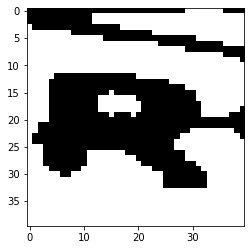

O rótulo é: R


In [106]:
x_train, y_train = pre_processing(1, 8001, 'CAPTCHA-10k/treinamento')
x_val, y_val = pre_processing(8001, 9001, 'CAPTCHA-10k/validacao')  
x_test, y_test = pre_processing(9001, 10001, 'CAPTCHA-10k/teste')

num = 0
img = (x_train[num]*255)

print("Imagem {}x{}".format(len(img), len(img[0])))
plt.imshow(img, cmap='gray')
plt.show()

print("O rótulo é:", int_to_char(y_train[num]))

## A Rede Neural Convolucional

### Definição da Arquitetura

Abaixo foi implementada a arquitetura para o classificador, para isso foram utilizadas camadas ...

In [14]:
def make_model(IMG_HEIGHT = 40, IMG_WIDTH = 40, NUMBER_OF_LABELS = 37):

    # Sequential layer
    model = Sequential()

    # CNN input layer
    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(IMG_HEIGHT,IMG_WIDTH, 1)))

    # hiden layers
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    # fully connected layer
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUMBER_OF_LABELS, activation='softmax'))

    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = make_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 20, 64)        0         
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 64)                1638464   
                                                        

### Treinamento

In [15]:
def train_model(model, NUMBER_OF_LABELS = 37, batch_size = 128, epochs = 1):
    
    response = model.fit(
            x_train, to_categorical(y = y_train, num_classes = NUMBER_OF_LABELS), 
            validation_data=(x_val, to_categorical(y_val, num_classes = NUMBER_OF_LABELS)),
            batch_size=batch_size, epochs=epochs, verbose=1
        )
    
    return model

### Carregando ou Treinando o Modelo

In [ ]:
"""model_path = './saved_model/'; model_file = 'saved_model.pb'

if  os.path.isfile(model_path + model_file):
    print('Um modelo treinado foi encontrado! Carregando Modelo...')     
    model = load_model(model_path)

else:    
    print('Trabalhando em um novo modelo...')
    train_model(model)
    model.save(model_path) """

In [105]:
model = train_model(model, batch_size = 128, epochs = 10)

Epoch 1/10
375/375 [==============================] - 148s 395ms/step - loss: 1.5137 - accuracy: 0.4847 - val_loss: 0.4808 - val_accuracy: 0.8643
Epoch 2/10
375/375 [==============================] - 151s 403ms/step - loss: 1.1972 - accuracy: 0.5884 - val_loss: 0.3812 - val_accuracy: 0.8990
Epoch 3/10
375/375 [==============================] - 147s 392ms/step - loss: 1.0062 - accuracy: 0.6549 - val_loss: 0.3459 - val_accuracy: 0.9073
Epoch 4/10
375/375 [==============================] - 147s 392ms/step - loss: 0.9374 - accuracy: 0.6775 - val_loss: 0.3229 - val_accuracy: 0.9133
Epoch 5/10
375/375 [==============================] - 147s 391ms/step - loss: 0.8750 - accuracy: 0.6985 - val_loss: 0.3063 - val_accuracy: 0.9177
Epoch 6/10
375/375 [==============================] - 147s 391ms/step - loss: 0.8392 - accuracy: 0.7092 - val_loss: 0.2924 - val_accuracy: 0.9210
Epoch 7/10
375/375 [==============================] - 147s 391ms/step - loss: 0.8154 - accuracy: 0.7187 - val_loss: 0.2888 -

In [107]:
model.history.history

{'loss': [1.5137298107147217,
  1.1972026824951172,
  1.0062257051467896,
  0.937428891658783,
  0.8750084042549133,
  0.8392260074615479,
  0.8153803944587708,
  0.7883075475692749,
  0.7612210512161255,
  0.7289297580718994],
 'accuracy': [0.48472917079925537,
  0.5883749723434448,
  0.6548958420753479,
  0.6775000095367432,
  0.6984999775886536,
  0.7091875076293945,
  0.718666672706604,
  0.729895830154419,
  0.7358958125114441,
  0.7503125071525574],
 'val_loss': [0.4807942807674408,
  0.38122305274009705,
  0.3459005057811737,
  0.322892427444458,
  0.30630162358283997,
  0.2924374043941498,
  0.2888115644454956,
  0.27819719910621643,
  0.27417147159576416,
  0.2696378529071808],
 'val_accuracy': [0.8643333315849304,
  0.8989999890327454,
  0.9073333144187927,
  0.9133333563804626,
  0.9176666736602783,
  0.9210000038146973,
  0.922166645526886,
  0.925166666507721,
  0.9275000095367432,
  0.9291666746139526]}

### Gráfico da Função de Perda - Validação e Treino

Utilizando-se o histórico do treinamento, é possível plotar os resultados intermediários para visualizarmos como a função de perda e a acurácia evoluiu ao longo das épocas.

In [117]:
history = model.history.history

accuracy_values = history['accuracy']
loss_values = history['loss']
val_loss_values = history['val_loss']

epochs = range(1, len(accuracy_values) + 1)

plt.figure(figsize = (16,10))
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.scatter(epochs, loss_values, 'r', label='Training loss')
plt.scatter(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

KeyError: 'accuracy'

### Gráfico da Acurácia - Validação e Treino

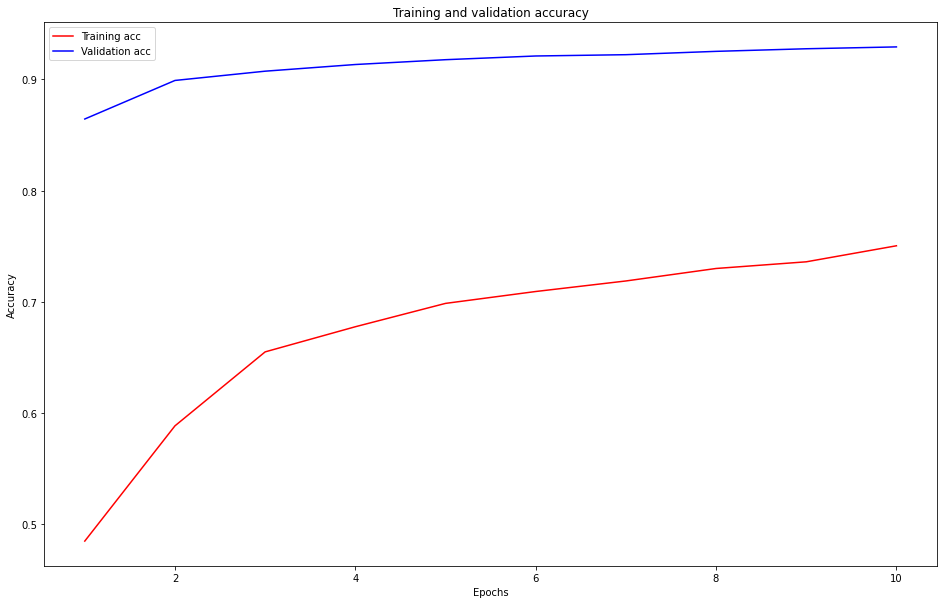

In [109]:
accuracy_values = history['accuracy']
valid_acc_values = history['val_accuracy']

plt.figure(figsize = (16,10))
plt.plot(epochs, accuracy_values, 'r', label='Training acc')
plt.plot(epochs, valid_acc_values, 'blue', label='Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Teste

In [110]:
def transform_output(char_pred):
    
    max_value = max(char_pred)
    idx = np.where(char_pred == max_value)
        
    return int_to_char(idx[0][0])

def get_string_output(img_pred):
    
    str_pred = ''
    for char_pred in img_pred:
        str_pred += transform_output(char_pred)
        
    return str_pred

def predict_pic(img_pred, original_img):

    plt.imshow(original_img, cmap='gray')
    plt.show()
    
    print(get_string_output(img_pred))
    
def test_model_with_image(model, max_displayed = 1000):
    
    imgs = read_images(9001, 9001 + max_displayed, 'CAPTCHA-10k/teste')
    
    print("Vamos mostrar {} imagens".format(max_displayed))
    
    for idx in range(0, max_displayed):
        l_range = 6 * idx; r_range = 6 * idx + 6
        img_pred = model.predict(x_test[l_range:r_range])
        predict_pic(img_pred, imgs[idx])
        

Vamos mostrar 4 imagens
1/1 [==============================] - 0s 21ms/step


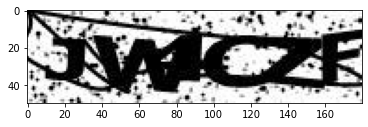

JW4CZF
1/1 [==============================] - 0s 22ms/step


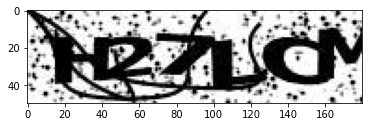

H27LCM
1/1 [==============================] - 0s 23ms/step


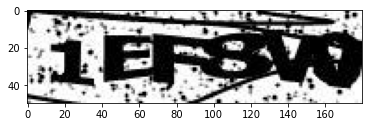

1EF8W9
1/1 [==============================] - 0s 23ms/step


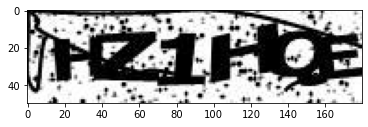

HZ1HOE


In [111]:
test_model_with_image(model, max_displayed = 4)

In [112]:
def test_model(model, x_test, y_test):
    
    correct_predict_captcha = {"0": 0, "1": 0, "2": 0, "3": 0, "4": 0 , "5": 0, "6": 0}
    
    img_pred = model.predict(x_test.reshape(6000,40,40,1))
    label_pred = np.argmax(img_pred, axis = 1)
    results = label_pred == y_test
    
    for idx in range(0, len(results), 6):
        hits = np.sum(results[idx:idx+6])
        correct_predict_captcha[str(hits)] += 1
        
    return label_pred, correct_predict_captcha

In [113]:
predictions, results_captcha = test_model(model, x_test, y_test)

188/188 [==============================] - 4s 23ms/step


## Matriz de Confusão

Para obervarmos melhor os resultados obtidos, podemos gerar a matriz de confusão e visualizá-la utilizando uma função de plotagem baseada em mapa de calor presente na biblioteca seaborn 

<AxesSubplot:>

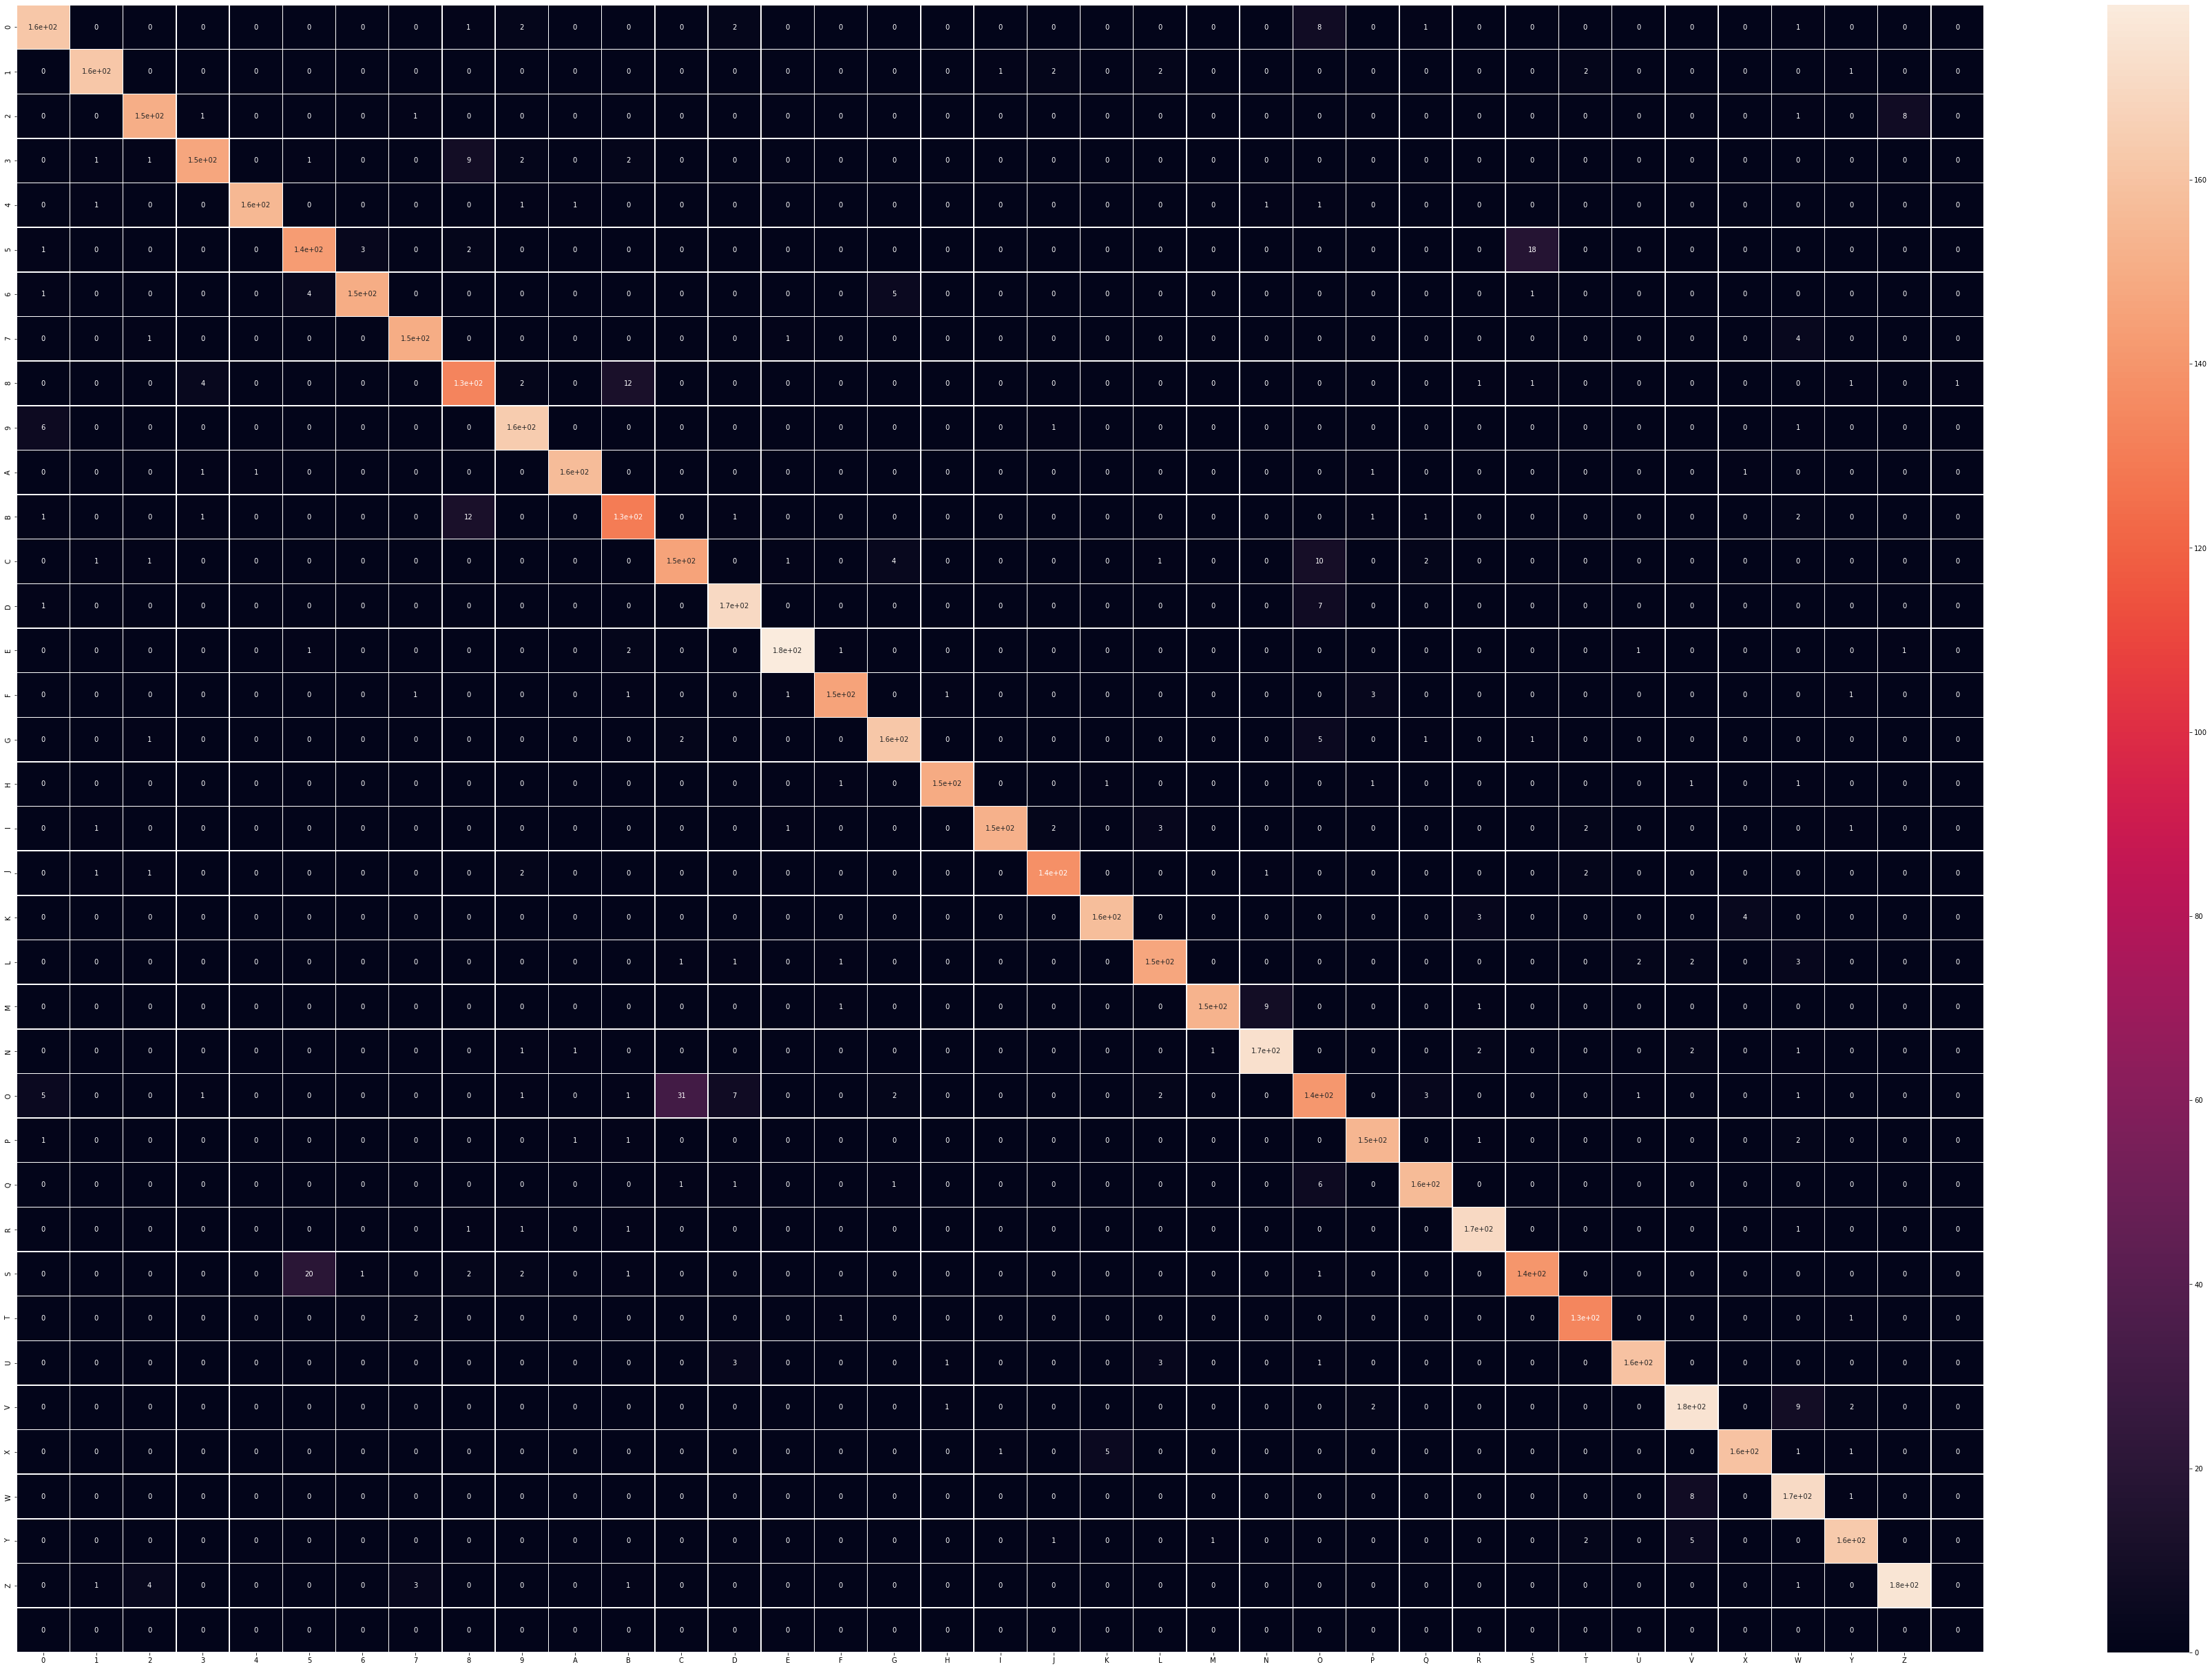

In [120]:
labels = ["0","1","2","3","4","5","6","7","8","9","A","B","C","D","E","F","G","H",\
          "I","J", "K","L","M","N","O","P","Q","R","S","T","U","V","X","W","Y","Z"]

conf_matrix = confusion_matrix(y_test, predictions)
_, axes = plt.subplots(figsize=(32,24))
sns.heatmap(conf_matrix, annot=True, xticklabels = labels, yticklabels = labels, linewidths=.5, ax=axes)

In [115]:
accuracy = accuracy_score(y_test, predictions)
print(f"A acurácia obtida foi: {accuracy:.4f}")

A acurácia obtida foi: 0.9297


## Resultados Captcha

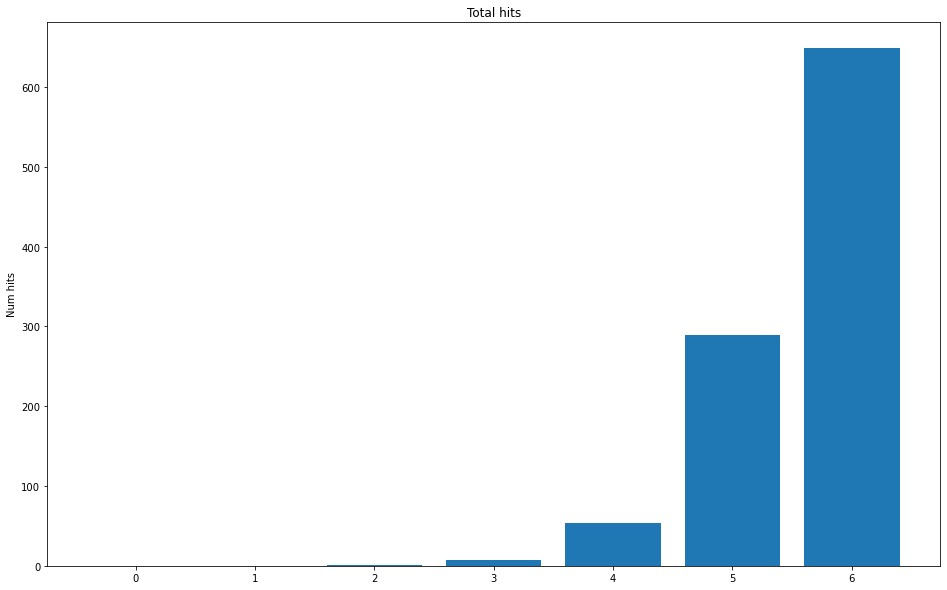

In [116]:
names = list(results_captcha.keys())
values = list(results_captcha.values())

plt.figure(figsize = (16,10))
plt.title('Total hits')
plt.ylabel('Num hits')

plt.bar(range(len(data)), values, tick_label=names)
plt.show()